# Previsione della Qualità dell'Aria - **Allenamento e Valutazione dei Modelli**

**Progetto di Data Intensive**  
**Autore:** Martin Tomassi, Jacopo Vasi  
**Email:** martin.tomassi@studio.unibo.it , jacopo.vasi@studio.unibo.it  
**Corso:** Data Intensive, Università di Bologna  
**Data:** Aprile 2025

## Caricamento dei Datasets ed Import Librerie



In [ ]:
import os
import requests
import zipfile
import io
import glob
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_log_error,
    explained_variance_score,
    max_error
)
from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV,
    GridSearchCV,
    KFold
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet
)

import xgboost as xgb
from IPython.display import clear_output
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor

%pip install xgboost
from xgboost import XGBRegressor

N_JOBS = -1
RANDOM_STATE = 42

augmented_path   = "Datasets/augmented_dataset.xls"
original_path   = "Datasets/original_dataset.xls"

# Augmented Dataset

aug_extract_to = "datasets/augmented"
os.makedirs(aug_extract_to, exist_ok=True)

with zipfile.ZipFile(zip_india_path, 'r') as z:
    z.extractall(aug_extract_to)

print("\nEstratti:\n")
for root, _, files in os.walk(aug_extract_to):
    for f in files:
        print(os.path.join(root, f))

# Original Dataset

orig_extract_to = "datasets/original"
os.makedirs(orig_extract_to, exist_ok=True)

with zipfile.ZipFile(zip_china_path, 'r') as z:
    z.extractall(orig_extract_to)

print("\nEstratti:\n")
for root, _, files in os.walk(orig_extract_to):
    for f in files:
        print(os.path.join(root, f))

Note: you may need to restart the kernel to use updated packages.
Running locally in Jupyter

Estratti:

datasets/india\AP001.csv
datasets/india\AP002.csv
datasets/india\AP003.csv
datasets/india\AP004.csv
datasets/india\AP005.csv
datasets/india\AP006.csv
datasets/india\AP007.csv
datasets/india\AP008.csv
datasets/india\AP009.csv
datasets/india\AP010.csv
datasets/india\AR001.csv
datasets/india\AS001.csv
datasets/india\AS002.csv
datasets/india\AS003.csv
datasets/india\AS004.csv
datasets/india\AS005.csv
datasets/india\AS006.csv
datasets/india\AS007.csv
datasets/india\AS008.csv
datasets/india\AS009.csv
datasets/india\BR001.csv
datasets/india\BR002.csv
datasets/india\BR003.csv
datasets/india\BR004.csv
datasets/india\BR005.csv
datasets/india\BR006.csv
datasets/india\BR007.csv
datasets/india\BR008.csv
datasets/india\BR009.csv
datasets/india\BR010.csv
datasets/india\BR011.csv
datasets/india\BR012.csv
datasets/india\BR013.csv
datasets/india\BR014.csv
datasets/india\BR015.csv
datasets/india\BR016

# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei due dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `weekofyear`: settimana dell'anno
- `hour`: ora del giorno
- `month`: mese dell’anno
- `dayofmonth`: giorno del mese
- `dayofweek`: giorno della settimana
- `dayofyear`: giorno dell’anno
- `quarter`: trimestre dell’anno
- `year`: anno della misurazione
- `CO`: concentrazione di monossido di carbonio
- `O3`: concentrazione di ozono
- `pm_lag_1Y`: PM2.5 ritardato di 1 anno
- `pm_lag_2Y`: PM2.5 ritardato di 2 anni

La variabile dipendente target dell'addestramento è `PM2.5`, che indica la concentrazione di particelle inquinanti nell'aria con un diametro inferiore a 2,5 micron (μm).

## Preparazione Dataset
Per garantire un confronto equo tra tutti i modelli, alcuni dei quali non supportano i valori mancanti generati dalle lag features, elimineremo tutte le righe che li contengono. Va però tenuto presente che così facendo perdiamo un anno di dati storici. Modelli come XGBoost o HistGradientBoostingRegressor di scikit-learn sono in grado di gestire internamente i missing value e potrebbero beneficiarne; tuttavia, per mantenere omogenee le condizioni di allenamento, applichiamo il drop completo dei NaN.

In [ ]:
target = 'PM2.5'
predictors = date_features + lag_features

In [ ]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    dataframe = dataframe.copy()

    if replace_na and how == 'zeros':
      dataframe = df.fillna(0)
    elif replace_na and how == 'drop':
      dataframe = df.dropna(how='any')

    train_set, test_set = np.split(dataframe, [int(len(df) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [ ]:
X_train, X_test, y_train, y_test = create_train_test_sets(df, split=0.8, replace_na=True, method='drop')
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

C:\Users\jacop\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Nel dataset, ci sono solo feature numeriche. Per le numeriche è necessario applicare una normalizzazione dei dati, i quali avrebbero altrimenti valori su scale molto diverse che renderebbero più difficile la convergenza del modello.

In [ ]:
preprocessor = ColumnTransformer([
    ( "numeric"    , StandardScaler(), predictors )
])

Inizializzazione della lista per raccogliere le metriche dopo ogni training

In [ ]:
all_scores = []

## Valutazione delle Prestazioni dei Modelli Allenati

Dopo l'allenamento di ciascun modello, utilizziamo la funzione `get_estimator_scores` per calcolare diverse metriche di valutazione, includendo per le principali anche gli **Intervalli di Confidenza al 95%** (CI95%) stimati tramite bootstrap resampling.

Le metriche calcolate sono:
1. $R^2$ (Coefficiente di Determinazione): questa metrica misura quanto bene un modello statistico riesce a spiegare la variabilità della variabile dipendente. Il valore di $R^2$ varia da 0 (nessuna capacità predittiva) a 1 (predizione perfetta). Un valore di $R^2_{test}$ significativamente inferiore rispetto a $R^2_{train}$ è un'indicazione di overfitting, ossia di una scarsa capacità del modello di generalizzare su dati mai visti.
(Più alto è, meglio è)

2. Root Mean Squared Error (RMSE): il RMSE misura la deviazione standard degli errori di previsione, ed è una versione "radice quadrata" del Mean Squared Error (MSE), che ne rappresenta invece la varianza. Entrambe penalizzano maggiormente gli errori più grandi.
(Più basso è, meglio è)

3. Mean Absolute Error (MAE): il MAE rappresenta la media delle differenze assolute tra i valori reali e quelli predetti. Rispetto all'RMSE, è meno sensibile agli outlier, poiché non amplifica gli errori più grandi.
(Più basso è, meglio è)

4. Mean Absolute Percentage Error (MAPE): il MAPE misura la precisione di un sistema di previsione in termini percentuali. Indica, in media, quanto si discosta una previsione rispetto al valore reale.
(Più basso è, meglio è)

5. Mean Squared Logarithmic Error (MSLE): utile quando si vuole penalizzare maggiormente gli errori relativi per valori piccoli e avere tolleranza su valori grandi.
(Più basso è, meglio è)

6. Explained Variance Score: misura la proporzione della varianza spiegata dal modello, simile a $R^2$, ma può essere più informativo in caso di regressione non lineare.
(Più alto è, meglio è)

7. Max Error: misura l'errore assoluto massimo commesso in una previsione.
(Più basso è, meglio è)

Questa funzione deve essere chiamata **dopo l’allenamento di ciascun modello**, ed è utile per confrontare più modelli tra loro, salvando le prestazioni in un DataFrame riepilogativo.


In [ ]:
def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    for _ in range(n_bootstraps):
        if running_in_colab:
            idx = np.random.randint(0, len(y_true), len(y_true))
            vals.append(metric_fn(y_true[idx], y_pred[idx]))
        else:
            idx = np.random.randint(0, len(y_true), len(y_true))
            vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx]))

    low = np.percentile(vals, 100 * (alpha/2))
    high = np.percentile(vals, 100 * (1 - alpha/2))
    return low, high

def get_estimator_scores(model_name, model):
    y_pred = model.predict(X_test)
    r2_tr = model.score(X_train, y_train)
    r2_te = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    msle = mean_squared_log_error(y_test, np.maximum(y_pred, 0))
    evs = explained_variance_score(y_test, y_pred)
    me = max_error(y_test, y_pred)

    rmse_low, rmse_high = bootstrap_ci(lambda a,b: np.sqrt(mean_squared_error(a, b)), y_test, y_pred)
    mae_low, mae_high = bootstrap_ci(mean_absolute_error, y_test, y_pred)
    mape_low, mape_high = bootstrap_ci(mean_absolute_percentage_error, y_test, y_pred)

    all_scores.append([
        model_name, r2_tr, r2_te,
        rmse, rmse_low, rmse_high,
        mae, mae_low, mae_high,
        mape, mape_low, mape_high,
        msle, evs, me
    ])

## Regressione lineare
Il modello più semplice da addestrare è la regressione lineare, senza filtri polinomiali o regolarizzazioni. Grazie all'elevato numero di dati usato per l'addestramento, si possono ottenere degli ottimi risultati, anche se migliorabili, già con questo primo modello.

In [ ]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , LinearRegression())
])

In [ ]:
%time model.fit(X_train, y_train)
get_estimator_scores("lin_reg", model)

CPU times: total: 46.9 ms
Wall time: 53.9 ms


## Regressione polinomiale
Per provare ad ottenere risultati migliori, vengono introdotte le feature polinomiali, che aggiungono nuove feature di grado superiore. Si esclude il bias, che consiste nel valore dell'intercetta, e si escludono i prodotti tra le diverse feature, per esempio i doppi prodotti in una regressione polinomiale di grado 2.

In [ ]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr"   , LinearRegression())
])

In [ ]:
%time model.fit(X_train, y_train)
get_estimator_scores("poly_reg", model)

CPU times: total: 1.08 s
Wall time: 374 ms


## Regressione LASSO
La regressione LASSO è un'ottima tecnica per selezionare le feature più importanti, poichè la discesa del gradiente si ferma su un vertice di un ipercubo centrato sull'origine, quindi azzera i parametri delle variabili meno rilevanti.

In [ ]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr", Lasso(alpha=1, max_iter=10000))
])

In [ ]:
%time model.fit(X_train, y_train)

CPU times: total: 109 ms
Wall time: 77.2 ms


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['hour', 'dayofmonth',
                                                   'dayofweek', 'dayofyear',
                                                   'weekofyear', 'month',
                                                   'quarter', 'year',
                                                   'pm_lag_1Y',
                                                   'pm_lag_2Y'])])),
                ('regr', Lasso(alpha=1, max_iter=10000))])

### Grid Search per l'iperparametro della Lasso
Per ricercare gli iperparametri migliori nei prossimi modelli da addestrare, verrà usata la grid search, che addestra il modello con tutte le combinazioni possibili di iperparametri selezionati. <br>
All'interno della grid search, suddividiamo i dati in 5 sottoinsiemi disgiunti, i fold della cross validation, per garantire che il modello riesca a generalizzare su dati non visti. <br>
Con la grid search si ottiene lo score del modello al variare dell'iperparametro della regolarizzazione LASSO per vedere quanta regolarizzazione è necessaria ai fini dell'addestramento.

In [ ]:
kf = KFold(5, shuffle=True, random_state=37)
alphas = np.logspace(-3, 1, num=5)
grid = {"regr__alpha": alphas}
gs = GridSearchCV(model, grid, cv=kf)

In [ ]:
%time gs.fit(X, y);
print()

C:\Users\jacop\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.325e+08, tolerance: 8.346e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.333e+08, tolerance: 8.347e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.338e+08, toleranc

CPU times: total: 14min 26s
Wall time: 5min 8s



C:\Users\jacop\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.172e+08, tolerance: 1.046e+05
  model = cd_fast.enet_coordinate_descent(


In [ ]:
get_estimator_scores("lasso_reg", gs.best_estimator_)

In [ ]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha", "mean_test_score"]]

Mostriamo ora i risultati appena ottenuti graficandoli.

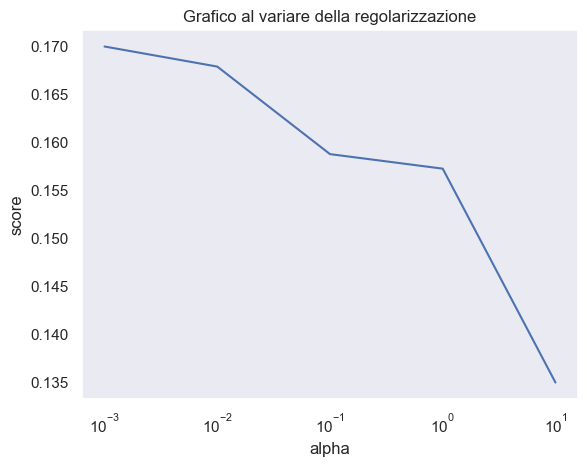

In [ ]:
plt.grid()
plt.plot(results["param_regr__alpha"], results["mean_test_score"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Grafico al variare della regolarizzazione')
plt.show()

Scegliamo il parametro minimo, ovvero 10<sup>-3</sup>, poichè otteniamo uno score massimo. Quindi concludiamo che aumentando la regolarizzazione LASSO peggiora il modello, perchè il vertice migliore dell'ipercubo è comunque troppo lontano dal minimo che si ottiene con i parametri ottimali di una regressione lineare senza regolarizzazione.

## Regressione Ridge
Proviamo la regolarizzazione con feature polinomiali per ridurre un eventuale overfitting.

In [ ]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", Ridge(alpha=1, max_iter=10000))
])

In [ ]:
%time model.fit(X_train, y_train)

CPU times: total: 297 ms
Wall time: 192 ms


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['hour', 'dayofmonth',
                                                   'dayofweek', 'dayofyear',
                                                   'weekofyear', 'month',
                                                   'quarter', 'year',
                                                   'pm_lag_1Y',
                                                   'pm_lag_2Y'])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('regr', Ridge(alpha=1, max_iter=10000))])

### Grid Search per l'iperparametro della Ridge

In [ ]:
alphas = np.logspace(-2, 3, num=6)
grid = {"regr__alpha": alphas}
gs = GridSearchCV(model, grid, cv=kf)

In [ ]:
%time gs.fit(X, y)
print()

CPU times: total: 8.73 s
Wall time: 7.34 s



In [ ]:
get_estimator_scores("ridge_reg", gs.best_estimator_)

In [ ]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha", "mean_test_score"]]

Mostriamo ora i risultati appena ottenuti graficandoli.

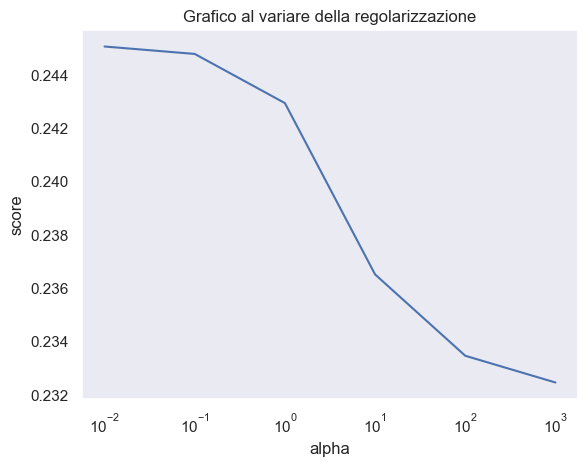

In [ ]:
plt.grid()
plt.plot(results["param_regr__alpha"], results["mean_test_score"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Grafico al variare della regolarizzazione')
plt.show()

La regolarizzazione applicata a feature polinomiali permette di individuare lo score massimo, in modo da evitare l'overfitting senza perdere di generalità. <br>
Lo score massimo si trova in corrispondenza di `alpha` = 10. Come si può vedere dal grafico, si ottengono score migliori quando la regolarizzazione è presente, ma non eccessiva.

## Regressione Elastic Net
Questa regressione unisce la regolarizzazione LASSO e la regolarizzazione Ridge.

In [ ]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", ElasticNet(alpha=0.2, l1_ratio=0.1))
])

In [ ]:
%time model.fit(X_train, y_train)

CPU times: total: 4.3 s
Wall time: 2.35 s


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['hour', 'dayofmonth',
                                                   'dayofweek', 'dayofyear',
                                                   'weekofyear', 'month',
                                                   'quarter', 'year',
                                                   'pm_lag_1Y',
                                                   'pm_lag_2Y'])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('regr', ElasticNet(alpha=0.2, l1_ratio=0.1))])

### Grid Search per Elastic Net
Nella grid search cerchiamo i valori migliori di `alpha`, iperparametro della regolarizzazione, e di `l1_ratio`, iperparametro per gestire l'unione di LASSO e Ridge.

In [ ]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__l1_ratio": [0.1, 0.2, 0.3]
}
gs = GridSearchCV(model, grid, cv=kf)

In [ ]:
%time gs.fit(X_train, y_train);
print()

CPU times: total: 2min 4s
Wall time: 50.1 s



In [ ]:
get_estimator_scores("elastic_net_reg", gs.best_estimator_)
gs.best_params_

{'regr__alpha': 0.1, 'regr__l1_ratio': 0.3}

## Regressione con funzioni kernel
Per ovviare ai problemi di prestazioni dei modelli con feature polinomiali, usiamo il kernel trick per evitare di creare un numero elevato di feature aggiuntive.

## Funzioni kernel polinomiali

In [ ]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr",  KernelRidge(alpha=1, kernel="poly", degree=10))
])

In [ ]:
%time model.fit(X_train, y_train)
print()

### Grid Search per funzioni kernel polinomiali
Questa grid search cerca i valori ottimali del peso della regolarizzazione e del grado della funzione kernel polinomiale.

In [ ]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__degree": list(range(2,30))
}
gs = GridSearchCV(model, grid, cv=kf)

In [ ]:
%time gs.fit(X_train, y_train)
print()

In [ ]:
get_estimator_scores("kernel_poly_reg", gs.best_estimator_)

In [ ]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha","param_regr__degree","mean_test_score"]]
results_0_1 = results[results["param_regr__alpha"] == 0.1]
results_1 = results[results["param_regr__alpha"] == 1]
results_10 = results[results["param_regr__alpha"] == 10]

In [ ]:
plt.grid()
plt.plot(results_0_1["param_regr__degree"], results_0_1["mean_test_score"])
plt.plot(results_1["param_regr__degree"], results_1["mean_test_score"], c="red")
plt.plot(results_10["param_regr__degree"], results_10["mean_test_score"], c="green")
plt.xlabel('degree')
plt.ylabel('score')
plt.legend(["alpha=0.1","alpha=1","alpha=10"])
plt.title('Grafico al variare del grado della funzione kernel polinomiale')
plt.show()

## Funzioni kernel gaussiane

Testiamo anche funzioni kernel diverse, ad esempio RBF (_radial basis function_). <br>
La funzione RBF ha la forma di una gaussiana.

In [ ]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr",  KernelRidge(alpha=1, kernel="rbf", gamma=0.01))
])

In [ ]:
%time model.fit(X_train, y_train)
print()

### Grid Search per funzioni kernel gaussiane

In [ ]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__gamma": [0.01, 0.1, 1]
}
gs = GridSearchCV(model, grid, cv=kf)

In [ ]:
%time gs.fit(X_train, y_train)
print()

In [ ]:
get_estimator_scores("kernel_rbf_reg", gs.best_estimator_)

## Alberi decisionali

In [ ]:
model = Pipeline([
    ("preproc", preprocessor),
    ("tree", DecisionTreeRegressor(max_depth=4, random_state=42))
])

In [ ]:
%time model.fit(X_train, y_train)
print()

### Grid Search per alberi decisionali
Cerchiamo i valori ottimali della profondità massima dell'albero decisionale e del numero minimo di campioni all'interno di ciascun nodo per poter essere suddiviso a sua volta.

In [ ]:
grid = {
    "tree__max_depth": list(range(4,30)),
    "tree__min_samples_split": [0.005, 0.01, 0.1, 0.15],
}
gs = GridSearchCV(model, grid, cv=kf)

In [ ]:
%time gs.fit(X_train, y_train)
print()

In [ ]:
get_estimator_scores("decision_tree_reg", gs.best_estimator_)

In [ ]:
results = pd.DataFrame(gs.cv_results_)[["param_tree__min_samples_split","param_tree__max_depth","mean_test_score"]]
results_0_005 = results[results["param_tree__min_samples_split"] == 0.005]
results_0_01 = results[results["param_tree__min_samples_split"] == 0.01]
results_0_1 = results[results["param_tree__min_samples_split"] == 0.1]
results_0_15 = results[results["param_tree__min_samples_split"] == 0.15]

In [ ]:
plt.grid()
plt.plot(results_0_005["param_tree__max_depth"], results_0_005["mean_test_score"], c="gold")
plt.plot(results_0_01["param_tree__max_depth"], results_0_01["mean_test_score"])
plt.plot(results_0_1["param_tree__max_depth"], results_0_1["mean_test_score"], c="red")
plt.plot(results_0_15["param_tree__max_depth"], results_0_15["mean_test_score"], c="green")
plt.xlabel('max depth')
plt.ylabel('score')
plt.legend(["min_samples_split=0.005","min_samples_split=0.01","min_samples_split=0.1","min_samples_split=0.15"])
plt.title("Grafico al variare della profondità massima dell'albero")
plt.show()

Dal grafico possiamo dedurre che quando una retta diventa orizzontale, significa che ha raggiunto la profondità massima per soddisfare il requisito del numero minimo di campioni in ciascun nodo dell'albero.

## Random forest

In [ ]:
model = Pipeline([
    ("preproc", preprocessor),
    ("tree", RandomForestRegressor(max_samples=0.2, max_features="sqrt", n_estimators=200, max_depth=None, n_jobs=-1))
])

In [ ]:
%time model.fit(X_train, y_train)
print()

Possiamo ricavare le 5 feature più importanti per la Random Forest, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [ ]:
pd.Series(model.named_steps["tree"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(5)

### Grid Search per random forest
Nella grid search cerchiamo i valori ottimali di `max_samples`, il numero massimo di campioni usati nell'addestramento di ciascun albero, e di `n_estimators`, il numero di alberi decisionali della foresta.

In [ ]:
grid = {
    "tree__n_estimators": [150, 200, 250, 300],
    "tree__max_samples": [0.5, 0.6, 0.8, 1.0],
}
gs = GridSearchCV(model, grid, cv=kf)

In [ ]:
%time gs.fit(X_train, y_train)
print()

In [ ]:
get_estimator_scores("random_forest_reg", gs.best_estimator_)

In [ ]:
results = pd.DataFrame(gs.cv_results_)[["param_tree__n_estimators","param_tree__max_samples","mean_test_score"]]
results_0_5 = results[results["param_tree__max_samples"] == 0.5]
results_0_6 = results[results["param_tree__max_samples"] == 0.6]
results_0_8 = results[results["param_tree__max_samples"] == 0.8]
results_1 = results[results["param_tree__max_samples"] == 1.0]

In [ ]:
plt.grid()
plt.plot(results_0_5["param_tree__n_estimators"], results_0_5["mean_test_score"])
plt.plot(results_0_6["param_tree__n_estimators"], results_0_6["mean_test_score"], c="red")
plt.plot(results_0_8["param_tree__n_estimators"], results_0_8["mean_test_score"], c="green")
plt.plot(results_1["param_tree__n_estimators"], results_1["mean_test_score"], c="gold")
plt.xlabel('n trees')
plt.ylabel('score')
plt.legend(["max_samples=0.5","max_samples=0.6","max_samples=0.8","max_samples=1"])
plt.title('Grafico al variare del numero di alberi del random forest')
plt.show()

## XGBoost
XGBoost crea una foresta di alberi in cui ogni albero utilizza gli errori commessi dall'albero precedente.

In [ ]:
model = Pipeline([
    ("preproc", preprocessor),
    ("xgb", XGBRegressor(objective='reg:squarederror', n_estimators=200))
])

In [ ]:
%time model.fit(X_train, y_train)
print()

Possiamo ricavare le 5 feature più importanti per XGBoost, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [ ]:
pd.Series(model.named_steps["xgb"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(5)

### Grid Search per XGBoost
Cerchiamo i valori ottimali di due iperparametri: la profondità massima degli alberi e il numero di alberi della foresta.

In [ ]:
grid = {
    "xgb__max_depth": [3, 5, 7, 10],
    "xgb__n_estimators": [100, 200, 400, 700, 1000],
}
gs = GridSearchCV(model, grid, cv=kf)

In [ ]:
%time gs.fit(X_train, y_train)
print()

In [ ]:
get_estimator_scores("xgboost_reg", gs.best_estimator_)

In [ ]:
results = pd.DataFrame(gs.cv_results_)[["param_xgb__max_depth","param_xgb__n_estimators","mean_test_score"]]
results_3 = results[results["param_xgb__max_depth"] == 3]
results_5 = results[results["param_xgb__max_depth"] == 5]
results_7 = results[results["param_xgb__max_depth"] == 7]
results_10 = results[results["param_xgb__max_depth"] == 10]

In [ ]:
plt.grid()
plt.plot(results_3["param_xgb__n_estimators"], results_3["mean_test_score"])
plt.plot(results_5["param_xgb__n_estimators"], results_5["mean_test_score"], c="red")
plt.plot(results_7["param_xgb__n_estimators"], results_7["mean_test_score"], c="green")
plt.plot(results_10["param_xgb__n_estimators"], results_10["mean_test_score"], c="gold")
plt.xlabel('n trees')
plt.ylabel('score')
plt.legend(["max_depth=3","max_depth=5","max_depth=7","max_depth=10"])
plt.title('Grafico al variare del numero del numero di alberi di XGBoost')
plt.show()

## Confronto Visivo delle Prestazioni dei Modelli

La funzione `plot_estimator_scores(scores)` consente di visualizzare in modo sintetico ed intuitivo le metriche di valutazione di tutti i modelli allenati. I grafici generati permettono un confronto diretto tra le prestazioni su diverse metriche chiave:

- **R² Score**: confronta le prestazioni sul training set e sul test set per identificare possibili fenomeni di overfitting.
- **RMSE (Root Mean Squared Error)**: evidenzia la variabilità degli errori di previsione, penalizzando fortemente gli outlier.
- **MAE (Mean Absolute Error)**: mostra la media dell’errore assoluto commesso da ciascun modello.
- **MAPE (Mean Absolute Percentage Error)**: fornisce un’indicazione dell’errore medio in termini percentuali rispetto ai valori reali.
- **MSLE (Mean Squared Logarithmic Error)**: utile nei casi in cui gli errori relativi siano più importanti degli assoluti, o in presenza di target con ordini di grandezza diversi.
- **Explained Variance Score**: indica la proporzione della varianza spiegata dal modello (simile a $R^2$).
- **Max Error**: evidenzia il peggior errore assoluto commesso su un'osservazione.
- **Intervalli di Confidenza (CI95%)**: per le metriche `RMSE`, `MAE` e `MAPE` viene stimato un intervallo di confidenza al 95% tramite bootstrap resampling, al fine di rappresentare l'incertezza statistica associata alla metrica.

> Assicurarsi che il DataFrame `scores` passato alla funzione contenga i valori calcolati correttamente tramite `get_estimator_scores` prima di richiamare questa funzione.

Questa visualizzazione finale è utile per trarre conclusioni sulla bontà predittiva di ciascun modello e guidare la scelta del miglior approccio da adottare.


In [ ]:
def plot_estimator_scores(scores):
    melted_r2 = scores[['model', 'r2_train', 'r2_test']]
    melted_r2 = melted_r2.rename(columns={'r2_train':'train','r2_test':'test'})
    melted_r2 = melted_r2.melt(id_vars='model', var_name='set', value_name='score')

    fig, axs = plt.subplots(3, 3, figsize=(18, 14))
    fig.tight_layout(pad=4)

    sns.barplot(data=melted_r2, x='score', y='model', hue='set', ax=axs[0,0])
    axs[0,0].set_title('R2 Score')
    axs[0,0].legend(loc='lower right')

    axs[0,1].set_title('RMSE ± CI95%')
    for _, row in scores.iterrows():
        axs[0,1].barh(row['model'], row['rmse'],
                      xerr=[[row['rmse']-row['rmse_low']], [row['rmse_high']-row['rmse']]], capsize=5)

    axs[0,2].set_title('MAE ± CI95%')
    for _, row in scores.iterrows():
        axs[0,2].barh(row['model'], row['mae'],
                      xerr=[[row['mae']-row['mae_low']], [row['mae_high']-row['mae']]], capsize=5)

    axs[1,0].set_title('MAPE ± CI95%')
    for _, row in scores.iterrows():
        axs[1,0].barh(row['model'], row['mape'],
                      xerr=[[row['mape']-row['mape_low']], [row['mape_high']-row['mape']]], capsize=5)

    axs[1,1].set_title('MSLE')
    for _, row in scores.iterrows():
        axs[1,1].barh(row['model'], row['msle'])

    axs[1,2].set_title('Explained Variance')
    for _, row in scores.iterrows():
        axs[1,2].barh(row['model'], row['explained_var'])
    axs[1,2].set_xlim(0,1)

    axs[2,0].set_title('Max Error')
    for _, row in scores.iterrows():
        axs[2,0].barh(row['model'], row['max_error'])

    axs[2,1].axis('off')
    axs[2,2].axis('off')

    plt.show()

In [ ]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'model','r2_train','r2_test',
        'rmse','rmse_low','rmse_high',
        'mae','mae_low','mae_high',
        'mape','mape_low','mape_high',
        'msle','explained_var','max_error'
    ]
)
plot_estimator_scores(estimator_scores_df)